<a href="https://colab.research.google.com/github/Steve-YJ/Assignment_Standalone_DL/blob/master/%5BLac4%5D_Lab6_report_result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! mkdir results

mkdir: cannot create directory ‘results’: File exists


In [ ]:
! ls

data  results  sample_data


In [ ]:
! ls

data  results  sample_data


# Import Library

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import argparse
import numpy as np
import time
from copy import deepcopy # Add Deepcopy for args

# Data Preparation

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
partition = {'train': trainset, 'val':valset, 'test':testset}

Files already downloaded and verified
Files already downloaded and verified


# Model Architecture

In [ ]:
class MLP(nn.Module):  # nn.Module 상속
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, dropout, use_bn, use_xavier):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.dropout = dropout
        self.use_bn = use_bn
        self.use_xavier = use_xavier
        
        # ====== Create Linear Layers ====== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        
        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn:
                self.bns.append(nn.BatchNorm1d(self.hid_dim))
                
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)
        
        # ====== Create Activation Function ====== #
        if self.act == 'relu':
            self.act = nn.ReLU()
        elif self.act == 'tanh':
            self.act == nn.Tanh()
        elif self.act == 'sigmoid':
            self.act = nn.Sigmoid()
        else:
            raise ValueError('no valid activation function selected!')
        
        # ====== Create Regularization Layer ======= #
        self.dropout = nn.Dropout(self.dropout)
        if self.use_xavier:
            self.xavier_init()
          
    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
            x = self.dropout(x)
        x = self.fc2(x)
        return x
    
    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)
            
net = MLP(3072, 10, 100, 4, 'relu', 0.1, True, True) # Testing Model Construction

# Train, Validate, Test and Experiment

In [ ]:
def train(net, partition, optimizer, criterion, args):
    trainloader = torch.utils.data.DataLoader(partition['train'], 
                                              batch_size=args.train_batch_size, 
                                              shuffle=True, num_workers=2)
    net.train()
    optimizer.zero_grad()

    correct = 0
    total = 0
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 3072)
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(trainloader)
    train_acc = 100 * correct / total
    return net, train_loss, train_acc

In [ ]:
def validate(net, partition, criterion, args):
    valloader = torch.utils.data.DataLoader(partition['val'], 
                                            batch_size=args.test_batch_size, 
                                            shuffle=False, num_workers=2)
    net.eval()

    correct = 0
    total = 0
    val_loss = 0 
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()
            outputs = net(images)

            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total
    return val_loss, val_acc

In [ ]:
def test(net, partition, args):
    testloader = torch.utils.data.DataLoader(partition['test'], 
                                             batch_size=args.test_batch_size, 
                                             shuffle=False, num_workers=2)
    net.eval()
    
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)
            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_acc = 100 * correct / total
    return test_acc

In [ ]:
def experiment(partition, args):

    net = MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.dropout, args.use_bn, args.use_xavier)
    net.cuda()

    criterion = nn.CrossEntropyLoss()
    if args.optim == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(net.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ================= Training ==================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        net, train_loss, train_acc = train(net, partition, optimizer, criterion, args)
        val_loss, val_acc = validate(net, partition, criterion, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.2f}/{:2.2f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(net, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    # 전체 결과값을 저장하는 Results Dic 
    # Q. 왜 때문인진 모르겠지만 train_accs와 train_acc가 분리되어있네?!
        # train_acc와 val_acc은 없어도 되는거 아냐?
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    # result['train_acc'] = train_acc
    # result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result  # vars(args)를 해주면 args를 dic로 저장해준다
    # ===================================== #

# Manage Experiment Result

* Manage Experiment Result
    * 실험 결과를 어떻게 관리할 것인가...!
    * <code>save_exp_result</code>
    * <code>load_exp_result</code>

In [25]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):  # setting: args
                                       # result : train_losses, val_losses, train_accs, val_accs,  
    exp_name = setting['exp_name']
    del setting['epoch']               # setting에서 'epoch'과 'test_batch_size'를 제거해준다고...
    del setting['test_batch_size']     # 왜 떼는거지?

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]  # setting에 따라 다른 파일명을 갖도록 만들어준다
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)  # 결과 dictionary에 setting값을 더해준다 => Dic
    with open(filename, 'w') as f:
        json.dump(result, f)  # JSON 포멧으로 dictionary 값 저장

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]  # ./resuts에 저장되어있는 file들을 리스트 형태로 저장
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            # print(exp_name)
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)  # Dic을 list형태로 저장
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

# Experiment

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123  # 랜덤 시드값 초기화
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_n_layer_hid_dim"

# ====== Model Capacity ====== #
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'n_layer'
name_var2 = 'hid_dim'
list_var1 = [1, 2, 3]
list_var2 = [500, 300]


for var1 in list_var1:
    for var2 in list_var2:
        # setattr ??: name_var1('n_layer')를 1, 2, 3으로 바꿔준다
        # setattr = args.name_var1 = var1
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0.2, epoch=10, exp_name='exp1_n_layer_hid_dim', hid_dim=500, in_dim=3072, l2=1e-05, lr=0.0015, n_layer=1, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 23.15/25.60, Loss(train/val) 26.60/26.67. Took 4.47 sec
Epoch 1, Acc(train/val): 26.58/24.89, Loss(train/val) 20.65/23.53. Took 4.32 sec
Epoch 2, Acc(train/val): 24.73/25.20, Loss(train/val) 21.07/24.86. Took 4.40 sec
Epoch 3, Acc(train/val): 27.51/25.05, Loss(train/val) 18.75/23.63. Took 4.34 sec
Epoch 4, Acc(train/val): 27.68/26.15, Loss(train/val) 16.51/18.11. Took 4.38 sec
Epoch 5, Acc(train/val): 27.31/28.00, Loss(train/val) 18.72/22.07. Took 4.46 sec
Epoch 6, Acc(train/val): 27.82/25.00, Loss(train/val) 17.87/26.68. Took 4.49 sec
Epoch 7, Acc(train/val): 27.64/25.16, Loss(train/val) 19.82/29.89. Took 4.43 sec
Epoch 8, Acc(train/val): 28.21/26.86, Loss(train/val) 17.95/21.44. Took 4.46 sec
Epoch 9, Acc(train/val): 28.60/2

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


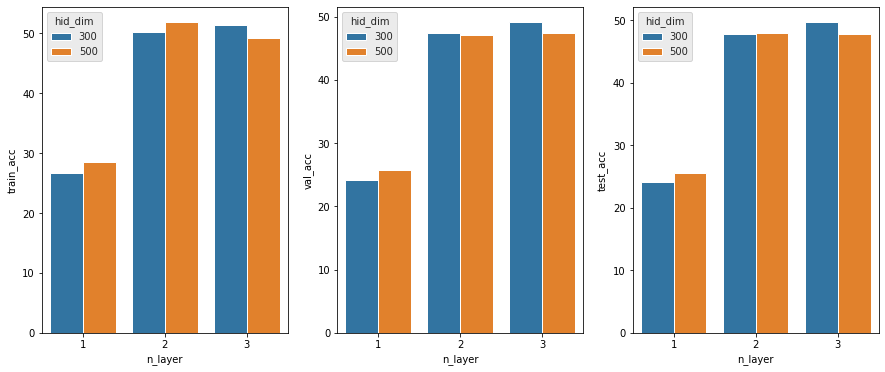

In [ ]:
import seaborn as sns 
import matplotlib.pyplot as plt

df = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 6)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=df, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=df, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=df, ax=ax[2])

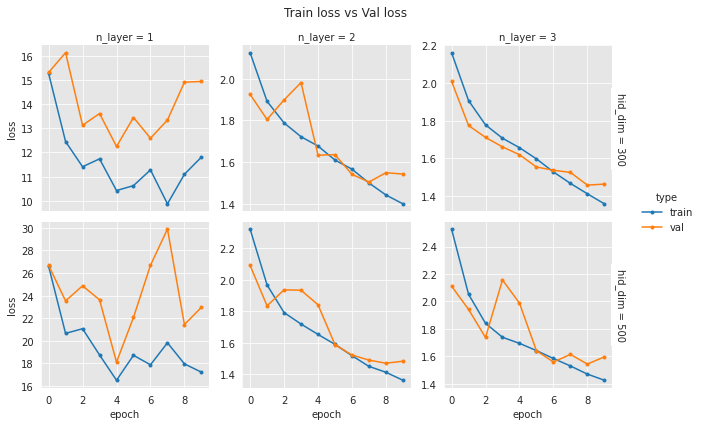

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

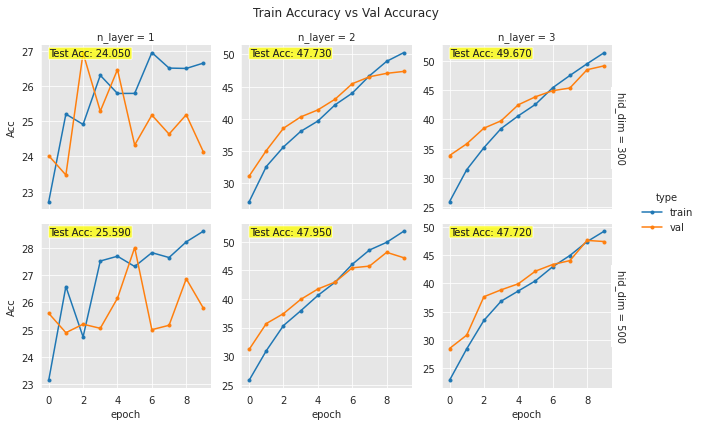

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [ ]:
!ls results

exp1_n_layer_hid_dim-41b634.json  exp1_n_layer_hid_dim-bfc899.json
exp1_n_layer_hid_dim-61a2d0.json  exp1_n_layer_hid_dim-cab8c1.json
exp1_n_layer_hid_dim-7b70fe.json  exp1_n_layer_hid_dim-dece45.json


In [ ]:
!cat results/exp1_n_layer_hid_dim-41b634.json

{"train_losses": [2.160004745623109, 1.9063878552928852, 1.7772650194775528, 1.7065156804528205, 1.6563499315529113, 1.5970130839924903, 1.5279524235209083, 1.4670166490943568, 1.411949109879269, 1.3587391376495361], "val_losses": [2.0082555651664733, 1.774195671081543, 1.7109267473220826, 1.6606235265731812, 1.6193002223968507, 1.5539405465126037, 1.5368509769439698, 1.525306487083435, 1.4579992651939393, 1.4634272694587707], "train_accs": [25.97, 31.43, 35.1875, 38.445, 40.6125, 42.5675, 45.3975, 47.4825, 49.485, 51.385], "val_accs": [33.85, 35.84, 38.51, 39.76, 42.49, 43.86, 44.89, 45.35, 48.47, 49.13], "train_acc": 51.385, "val_acc": 49.13, "test_acc": 49.67, "exp_name": "exp1_n_layer_hid_dim", "in_dim": 3072, "out_dim": 10, "hid_dim": 300, "act": "relu", "dropout": 0.2, "use_bn": true, "l2": 1e-05, "use_xavier": true, "optim": "RMSprop", "lr": 0.0015, "train_batch_size": 256, "n_layer": 3}

* 실험 결과
    * 📌 실험 setting값과 결과값을 하드디스크에 잘 저장할 수 있게 되었다...! -20.09.24.Thur. pm12:30-
* Next
    * pandas에 결과값을 저장하고 저장된 값들을 불러와 시각화해보자!

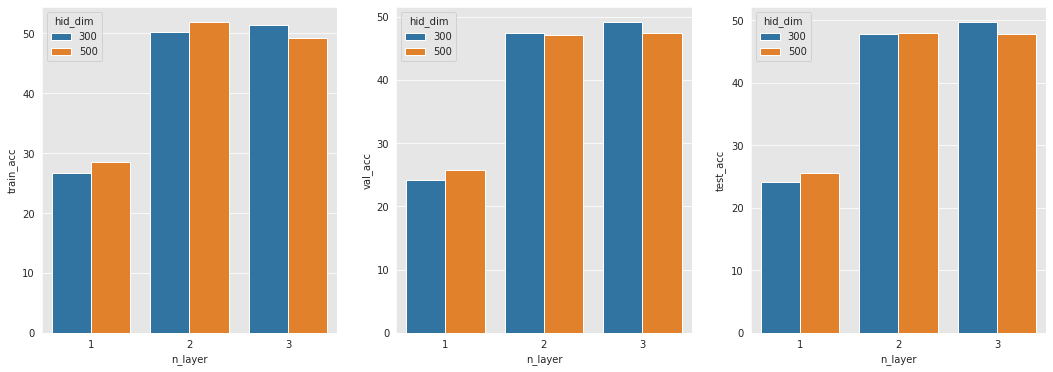

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

result = load_exp_result('exp1')

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(18, 6)

sns.barplot(x='n_layer', y='train_acc', hue='hid_dim', data=result, ax=ax[0])
sns.barplot(x='n_layer', y='val_acc', hue='hid_dim', data=result, ax=ax[1])
sns.barplot(x='n_layer', y='test_acc', hue='hid_dim', data=result, ax=ax[2])

[3 2 1] [300 500]


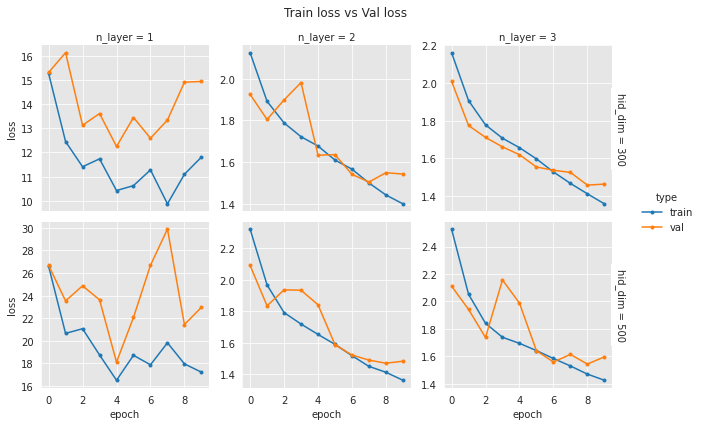

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()  # pandas dataframe에서 유니크한 집합 추출
list_v2 = df[var2].unique()
list_data = []

print('='*20)
print(list_v1, list_v2)


for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_losses = list(row.train_losses)[0]
        val_losses = list(row.val_losses)[0]
        
        for epoch, train_loss in enumerate(train_losses):
            list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_loss in enumerate(val_losses):
            list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
"""
FaceGrid: 그림이 그려질 그리드...!

"""
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'loss', marker='.')
g.add_legend()
g.fig.suptitle('Train loss vs Val loss')
plt.subplots_adjust(top=0.89)

* 그래프 해석
    * 그래프의 x축은(n_layer) 레이어의 개수
    * 그래프의 y축은(hid_dim) 히든 레이어의 개수
    * 그래프 안의 x축은 epoch
    * 그래프 안의 y축은 loss

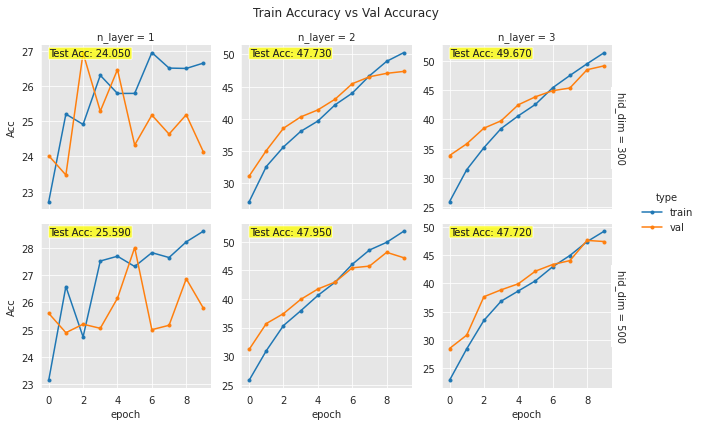

In [ ]:
var1 = 'n_layer'
var2 = 'hid_dim'

df = load_exp_result('exp1')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

In [ ]:
# ====== Random Seed Initialization ====== #
seed = 123  # 랜덤 시드값 초기화
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp2_lr_dropout"

# ====== Model Capacity ====== #
args.n_layer = 3
args.in_dim = 3072
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# ====== Regularization ======= #
# args.dropout = 0.2
args.use_bn = True
args.l2 = 0.00001
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
# args.lr = 0.0015
args.epoch = 10

args.train_batch_size = 256
args.test_batch_size = 1024

# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'dropout'
list_var1 = [0.0005, 0.001, 0.005]
list_var2 = [0, 0.1, 0.2, 0.3]


for var1 in list_var1:
    for var2 in list_var2:
        # setattr ??: name_var1('n_layer')를 1, 2, 3으로 바꿔준다
        # setattr = args.name_var1 = var1
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

Namespace(act='relu', dropout=0, epoch=10, exp_name='exp2_lr_dropout', hid_dim=100, in_dim=3072, l2=1e-05, lr=0.0005, n_layer=3, optim='RMSprop', out_dim=10, test_batch_size=1024, train_batch_size=256, use_bn=True, use_xavier=True)
Epoch 0, Acc(train/val): 34.78/37.83, Loss(train/val) 1.81/1.72. Took 4.60 sec
Epoch 1, Acc(train/val): 39.19/39.32, Loss(train/val) 1.69/1.66. Took 4.60 sec
Epoch 2, Acc(train/val): 41.58/41.79, Loss(train/val) 1.63/1.61. Took 4.55 sec
Epoch 3, Acc(train/val): 44.00/43.63, Loss(train/val) 1.56/1.55. Took 4.48 sec
Epoch 4, Acc(train/val): 46.75/45.24, Loss(train/val) 1.48/1.53. Took 4.56 sec
Epoch 5, Acc(train/val): 49.14/45.78, Loss(train/val) 1.42/1.50. Took 4.55 sec
Epoch 6, Acc(train/val): 51.05/47.07, Loss(train/val) 1.37/1.48. Took 4.65 sec
Epoch 7, Acc(train/val): 52.83/48.04, Loss(train/val) 1.32/1.45. Took 4.56 sec
Epoch 8, Acc(train/val): 54.28/48.66, Loss(train/val) 1.28/1.46. Took 4.48 sec
Epoch 9, Acc(train/val): 56.09/48.87, Loss(train/val) 1.2

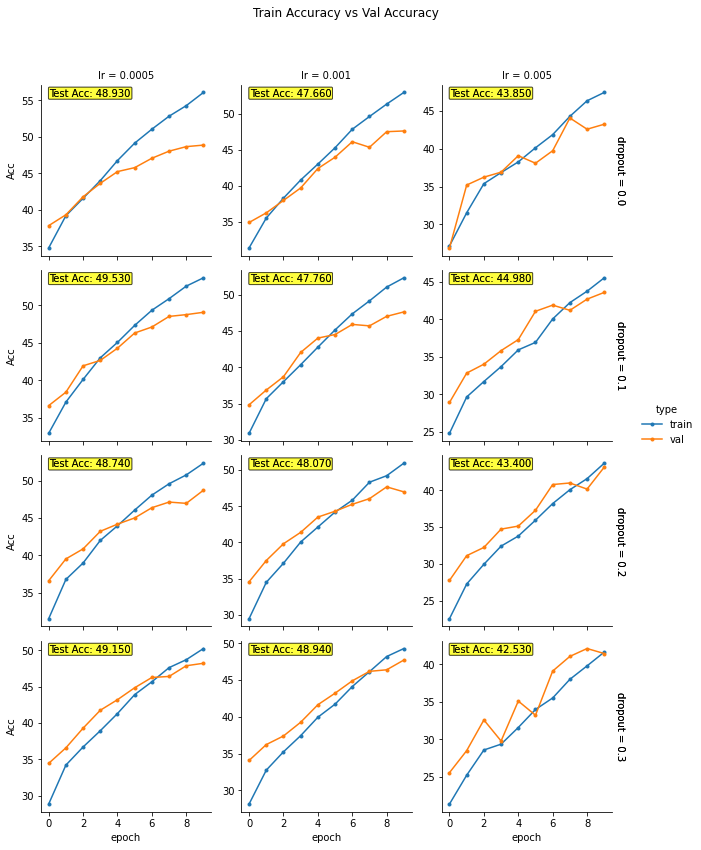

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt


var1 = 'lr'
var2 = 'dropout'

df = load_exp_result('exp2')
list_v1 = df[var1].unique()
list_v2 = df[var2].unique()
list_data = []

for value1 in list_v1:
    for value2 in list_v2:
        row = df.loc[df[var1]==value1]
        row = row.loc[df[var2]==value2]
        
        train_accs = list(row.train_accs)[0]
        val_accs = list(row.val_accs)[0]
        test_acc = list(row.test_acc)[0]
        
        for epoch, train_acc in enumerate(train_accs):
            list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        for epoch, val_acc in enumerate(val_accs):
            list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
        
df = pd.DataFrame(list_data)
g = sns.FacetGrid(df, row=var2, col=var1, hue='type', margin_titles=True, sharey=False)
g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

def show_acc(x, y, metric, **kwargs):
    plt.scatter(x, y, alpha=0.3, s=1)
    metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
    plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

g.add_legend()
g.fig.suptitle('Train Accuracy vs Val Accuracy')



plt.subplots_adjust(top=0.89)

# Appendix

## Pandas

In [ ]:
print(type(load_exp_result('exp1')))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
a = [{'age': 5, 'gender':'f', 'score': 10}, {'age':6, 'gender': 'm', 'score': 9}, 
     {'age': 4, 'gender': 'm', 'score': 8}, {'age':10, 'gender': 'f', 'score': 5},
     {'age': 10, 'gender':'f', 'score': 15}, {'age':6, 'gender': 'f', 'score': 15},
     {'age': 5, 'gender':'f', 'score': 10}, {'age':6, 'gender': 'm', 'score': 9},
     {'age': 12, 'gender':'f', 'score': 11}, {'age':4, 'gender': 'f', 'score': 5},]
df = pd.DataFrame(a)
df

,age,gender,score
0,5,f,10
1,6,m,9
2,4,m,8
3,10,f,5
4,10,f,15
5,6,f,15
6,5,f,10
7,6,m,9
8,12,f,11
9,4,f,5


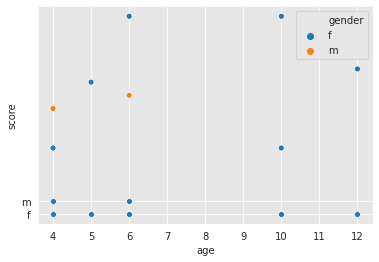

In [ ]:
import seaborn as sns

sns.scatterplot(x='age', y='gender', data=df)
sns.scatterplot(x='age', y='score', hue='gender', data=df)

## Summary
* 향후 실험에서 사용하기 위한 조건
    * 1. 작업 위치를 현재 디렉터리로 변경한다 -> google.colab -> Divce Mount
    * 2. save_exp_result와 load_exp_result함수 및 활용법을 잘 익혀두자
    * Timestamp: 20.09.24.Thur. pm 5:00~